In [1]:
# !gdown 1dQC6v3Z3FgNVO__HL8mQVjTvmNdvobe5

In [1]:
import torch
from torch import nn
from torchsummary import summary
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import scipy
import torch.nn.functional as F
from scipy.signal import spectrogram
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
warnings.filterwarnings('ignore')
%matplotlib inline
device = 'cuda:0'

# To do:  
1. Preproccess data from edf to csv +
2. First approach based on spectrograms.
3. Second approach http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2018/paper/ABCs2018_paper_216.pdf create rgb image.
4. Third approach: https://sci-hub.hkvisa.net/10.1109/ACCESS.2018.2833746
5. Compare different classifiers.

# Comments  
1. There are 89 recordings with 21 channels and 9 recordings with 22 channels, so for the former I will take only 21 which are presented in the latter. Look at common_electrodes.
2. For the first approch it is strictly necessary for all recordings to be the same length (I will take windows 4096 as in the paper).

In [2]:
PATH = 'eeg_data/'
PATH_TO_SAVE = 'eeg_data_csv/'
# PATH_TO_SAVE_TENSORS = 'eeg_data_spec_tensors/'
PATH_TO_SAVE_TENSORS = 'eeg_data_spec_tensors_unnorm/'

In [3]:
# parameters are acquired during EDA
common_electrodes = ['EEG FP1-R', 'EEG FP2-R', 'EEG F3-R', 'EEG F4-R', 'EEG C3-R', 'EEG C4-R', 
                     'EEG P3-R', 'EEG P4-R', 'EEG O1-R', 'EEG O2-R', 'EEG F7-R', 'EEG F8-R', 
                     'EEG T3-R', 'EEG T4-R', 'EEG T5-R', 'EEG T6-R', 'EEG FPZ-R', 'EEG FZ-R', 
                     'EEG CZ-R', 'EEG PZ-R', 'EEG OZ-R']


min_length = 21500
filter_params = {'l_freq': 1, 'h_freq': 50, 'method': 'iir', 'n_jobs': -1, 'verbose': False}
Fs = 500

In [4]:
def get_np_from_edf(path_to_data, filter_params, path_to_save):
    for cls in os.listdir(path_to_data):
        for recording in os.listdir(path_to_data + f'{cls}/'):
            filename = path_to_data + f'{cls}/' + recording
            sample = mne.io.read_raw_edf(filename, verbose = False, preload = True)
            if 'EEG 2-R' in sample.ch_names:
                sample.drop_channels(['EEG 2-R'])
#             sample.filter(**filter_params)
            sample = sample.to_data_frame(common_electrodes)[common_electrodes]
            if not os.path.isdir(path_to_save + f'{cls}'):
                os.mkdir(path_to_save + f'{cls}')
            sample.to_csv(path_to_save + f'{cls}/' + f'{recording[:-4]}.csv')

In [5]:
def normalise_spect(spectrogram):
    min_value = np.min(spectrogram)
    max_value = np.max(spectrogram)
    spectrogram = 255 * (spectrogram - min_value) / (max_value - min_value)
    return np.round(spectrogram).astype(int)

In [6]:
# is bandlimited from 1 to 50 Hz
# w grows from the bottom to the top
# time grows from the left to the right
def get_spectrogram(path_to_data, path_to_save, Fs):
    for cls in os.listdir(path_to_data):
        for recording in os.listdir(path_to_data + f'{cls}/'):
            data = pd.read_csv(path_to_data + f'{cls}/' + recording)
            data = data.iloc[:min_length]
            data_to_cat = []
            for channel in data.columns[1:]:
                freq, time, values = spectrogram(data[channel], Fs)
                idx = np.where((freq > 1) & (freq < 50))[0]
                freq = freq[idx]
                #pad to 24;96
                values = values[idx[1:], :]
                values = 20 * np.log10(values)
                pad = np.zeros((values.shape[0], 1))
#                 values = normalise_spect(values)
                values = np.hstack((values, pad))
                data_to_cat.append(torch.from_numpy(np.flip(values, axis = (0)).copy()).unsqueeze_(0))
            tensor_with_all_channels = torch.cat(data_to_cat, dim = 0)
            if not os.path.isdir(path_to_save + f'{cls}'):
                os.mkdir(path_to_save + f'{cls}')
            torch.save(tensor_with_all_channels, 
                       path_to_save + f'{cls}/' + f'{recording[:-4]}.pt')

In [7]:
# get_np_from_edf(PATH, filter_params, PATH_TO_SAVE)
# get_spectrogram(PATH_TO_SAVE, PATH_TO_SAVE_TENSORS, Fs)

In [8]:
# test = torch.load('eeg_data_spec_tensors/Health/S1001.pt')
# mne_test = mne.io.read_raw_edf('eeg_data/Health/S232.edf').to_data_frame()
# a = mne_test['EEG FP1-R'].to_numpy()
# freq, time, values = spectrogram(a, Fs)
# idx = np.where((freq > 1) & (freq < 50))[0]
# freq = freq[idx]
# values = values[idx[1:], :]
# values = 20 * np.log10(values)
# pad = np.zeros((values.shape[0], 1))
# print(values.shape)
# values = normalise_spect(values)
# values = np.hstack((values, pad))

# Model for approach 1

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(EncoderBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = channels_in, 
                      out_channels = channels_out, 
                      stride = 1, 
                      padding = 1, 
                      kernel_size = 3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = channels_out))
#             nn.InstanceNorm2d(num_features = channels_out))
        self.dropout = nn.Dropout(0.25)
        self.avgpool = nn.MaxPool2d(kernel_size = 2, padding = 0, stride = 2)
    def forward(self, inputs):
#         print(inputs.shape)
        out = self.layer(inputs)
        out = self.dropout(out)
        out = self.avgpool(out)
        return out

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels = channels_in,
                                            out_channels = channels_in,
                                            kernel_size = 3,
                                            stride = 2,
                                            padding = 1,
                                            output_padding = 1)
        self.layer = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels = channels_in, 
                          out_channels = channels_out, 
                          stride = 1, 
                          padding = 1, 
                          kernel_size = 3),
            nn.BatchNorm2d(num_features = channels_out))
#             nn.InstanceNorm2d(num_features = channels_out))
        self.dropout = nn.Dropout(0.25)
    def forward(self, inputs):
#         print(inputs.shape)
        out = self.upsample(inputs)
#         print(out.shape)
        out = self.layer(out)
        out = self.dropout(out)
        return out

In [16]:
class ConvAE(nn.Module):
    def __init__(self, num_enc_blocks = 1, input_channels = 21):
        super(ConvAE, self).__init__()
        self.encoder_block = nn.ModuleList()
        self.decoder_block = nn.ModuleList()
        channels_in_encoder = []
        channels_out_encoder = []
        channels_in_decoder = []
        channels_out_decoder = []
        for i in range(num_enc_blocks):
            channels_in_encoder.append(2 ** i * input_channels)
            channels_out_encoder.append(2 ** (i + 1) *  input_channels)
        channels_in_decoder = channels_out_encoder[::-1]
        channels_out_decoder = channels_in_encoder[::-1]
        for i in range(num_enc_blocks):
            self.encoder_block.append(EncoderBlock(channels_in_encoder[i],
                                                   channels_out_encoder[i]))
            self.decoder_block.append(DecoderBlock(channels_in_decoder[i],
                                                   channels_out_decoder[i]))
        self.max_pool_spatial = nn.MaxPool2d(kernel_size = 2, padding = 0, stride = 2)
        self.tanh = nn.Tanh()
    def forward(self, inputs):
        x = inputs
        for block in self.encoder_block:
            x = block(x)
        # somehow get x from this and do what I want
        lattent_space = x.clone().detach()
        batch_size = lattent_space.shape[0]
        lattent_space = self.max_pool_spatial(lattent_space)
        lattent_space_mean = torch.mean(lattent_space, dim = 1)
        lattent_space_max = torch.max(lattent_space, dim = 1)[0]
        lattent_space_mean = torch.flatten(lattent_space_mean)
        lattent_space_mean = lattent_space_mean.reshape(batch_size, -1)
        lattent_space_max = torch.flatten(lattent_space_max)
        lattent_space_max = lattent_space_max.reshape(batch_size, -1)
#         print(lattent_space_max.shape)
#         print(lattent_space_mean.shape)
        vectorized_lattent_space = torch.cat([lattent_space_mean, lattent_space_max], dim = 1)
        
        for block in self.decoder_block:
            x = block(x)
        x = self.tanh(x)
        return x, vectorized_lattent_space

## Dataset

In [17]:
class EegSpec(Dataset):
    def __init__(self,
                 phase: str,
                 data_path: str = 'data'):
        files = os.listdir(f'{data_path}/{phase}')
        self.images = []
        for f in files:
            self.images.append(torch.load(f'{data_path}/' + f'{phase}/' + f))
                         
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

In [18]:
BATCH = 8
epoches = 100
train_data = EegSpec(phase = 'train')
validate_data = EegSpec(phase = 'validate')
train_dataloader = DataLoader(train_data, batch_size = BATCH, 
                              shuffle = True, num_workers = 4) 
validation_dataloader = DataLoader(validate_data, batch_size = 10, 
                                   shuffle = False, num_workers = 4)

In [24]:
model = ConvAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.L1Loss()

In [25]:
test_tensor = torch.randn(BATCH, 21, 24, 96).to(device)

In [26]:
t = model(test_tensor)

In [29]:
t[0].max()

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)

In [21]:
# def normalise_tensor(tensor):
#     for channel in range(tensor.shape[-3]):
#         min_v = torch.min(tensor[channel])
#         max_v = torch.max(tensor[channel])
#         tensor[channel] = 255 * (tensor[channel] - min_v) / (max_v - min_v)
#         tensor[channel] = tensor[channel].to(torch.int)
#     return tensor

In [30]:
n = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [31]:
tt =torch.from_numpy(n)

In [32]:
n

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [33]:
tt

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

## Training

In [22]:
def train(model, epoches, train_dataloader, validation_dataloader, device, criterion):
    model = model.to(device)
    for epoch in range(epoches):
        train_loss = 0
        for data in train_dataloader:
            img = data.to(device, dtype = torch.float)
            output = model(img)[0]
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(train_loss.item())
            train_loss += loss.item()
        train_loss = train_loss / len(train_dataloader)

        model.eval() 
        val_loss = 0
        with torch.no_grad():
            for img in validation_dataloader:
                img = data.to(device, dtype = torch.float)
                output = model(img)[0]
                val_loss = criterion(output, img)
                val_loss += val_loss.item()
            val_loss = val_loss / len(validation_dataloader)
        print(f'epoch {epoch}/{epoches}\n train loss: {train_loss}\n validation_loss {val_loss}')

In [23]:
train(model, 100, train_dataloader, validation_dataloader, device, criterion)

epoch 0/100
 train loss: nan
 validation_loss nan
epoch 1/100
 train loss: nan
 validation_loss nan
epoch 2/100
 train loss: nan
 validation_loss nan
epoch 3/100
 train loss: nan
 validation_loss nan
epoch 4/100
 train loss: nan
 validation_loss nan
epoch 5/100
 train loss: nan
 validation_loss nan
epoch 6/100
 train loss: nan
 validation_loss nan
epoch 7/100
 train loss: nan
 validation_loss nan
epoch 8/100
 train loss: nan
 validation_loss nan
epoch 9/100
 train loss: nan
 validation_loss nan
epoch 10/100
 train loss: nan
 validation_loss nan


KeyboardInterrupt: 

In [77]:
test_img = torch.load('data/train/F117.pt').to(device, dtype = torch.float)

In [78]:
test_img[0].cpu().detach().numpy()

array([[-8.93113937e+01, -9.52984314e+01, -8.71266251e+01, ...,
        -9.58179703e+01, -1.10192940e+02,  0.00000000e+00],
       [-1.08356728e+02, -9.39901657e+01, -8.06325531e+01, ...,
        -8.63366013e+01, -1.02290565e+02,  0.00000000e+00],
       [-8.27456970e+01, -9.39482269e+01, -7.83746872e+01, ...,
        -8.14996643e+01, -8.20751648e+01,  0.00000000e+00],
       ...,
       [ 4.03068008e+01, -1.48258913e+00,  1.43637991e+01, ...,
         4.91469316e-02,  3.54411340e+00,  0.00000000e+00],
       [ 5.02587852e+01, -1.20453119e+00, -9.37911749e-01, ...,
         6.11813021e+00, -2.02806664e+00,  0.00000000e+00],
       [ 4.84067764e+01,  1.15274296e+01,  8.94883251e+00, ...,
         1.95311964e+00,  6.13993311e+00,  0.00000000e+00]], dtype=float32)

In [79]:
l = nn.MSELoss()

In [80]:
l(test_img, out[0])

tensor(2376.5715, device='cuda:0', grad_fn=<MseLossBackward0>)

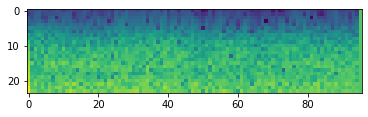

In [81]:
plt.imshow(test_img[0].cpu().detach().numpy())

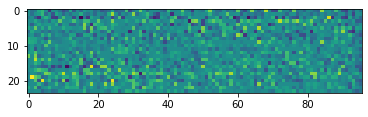

In [82]:
plt.imshow(out[0][0].cpu().detach().numpy())

In [45]:
out[0]

tensor([[[ 0.0000e+00, -1.0610e+00, -6.5021e-01,  ..., -1.6554e+00,
           0.0000e+00, -9.2072e-01],
         [ 0.0000e+00, -1.0904e+00,  1.4517e-01,  ..., -2.5557e+00,
           1.0986e-01,  0.0000e+00],
         [-6.1692e-01,  0.0000e+00, -1.6940e+00,  ..., -1.3609e+00,
          -1.1498e-01, -1.2353e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1066e+00,
          -4.8195e-01, -1.3187e+00],
         [ 9.7923e-01,  0.0000e+00,  2.0117e+00,  ...,  5.9333e-01,
           0.0000e+00, -4.7736e-01],
         [ 0.0000e+00, -2.1497e-01,  0.0000e+00,  ..., -8.7041e-01,
          -1.6052e+00, -9.1026e-01]],

        [[-3.1829e-01,  4.6454e-01,  7.0107e-01,  ..., -5.9756e-01,
           4.2950e-01, -1.3584e-01],
         [-1.4911e+00,  2.9224e-01, -2.2485e-01,  ..., -7.1799e-01,
          -9.2773e-01,  5.9316e-01],
         [ 0.0000e+00,  0.0000e+00, -2.6911e-01,  ...,  1.9789e+00,
          -1.9354e+00, -9.8757e-01],
         ...,
         [ 8.1543e-02, -1

In [42]:
out = model(test_img)

In [43]:
out[0]

tensor([[[ 0.0000e+00, -1.0610e+00, -6.5021e-01,  ..., -1.6554e+00,
           0.0000e+00, -9.2072e-01],
         [ 0.0000e+00, -1.0904e+00,  1.4517e-01,  ..., -2.5557e+00,
           1.0986e-01,  0.0000e+00],
         [-6.1692e-01,  0.0000e+00, -1.6940e+00,  ..., -1.3609e+00,
          -1.1498e-01, -1.2353e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1066e+00,
          -4.8195e-01, -1.3187e+00],
         [ 9.7923e-01,  0.0000e+00,  2.0117e+00,  ...,  5.9333e-01,
           0.0000e+00, -4.7736e-01],
         [ 0.0000e+00, -2.1497e-01,  0.0000e+00,  ..., -8.7041e-01,
          -1.6052e+00, -9.1026e-01]],

        [[-3.1829e-01,  4.6454e-01,  7.0107e-01,  ..., -5.9756e-01,
           4.2950e-01, -1.3584e-01],
         [-1.4911e+00,  2.9224e-01, -2.2485e-01,  ..., -7.1799e-01,
          -9.2773e-01,  5.9316e-01],
         [ 0.0000e+00,  0.0000e+00, -2.6911e-01,  ...,  1.9789e+00,
          -1.9354e+00, -9.8757e-01],
         ...,
         [ 8.1543e-02, -1

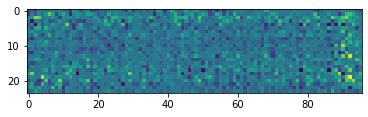

In [81]:
plt.imshow(out[0].cpu().detach().numpy())

In [77]:
model(test_img)[0]

tensor([[[ 0.0000,  0.0000, -1.2339,  ...,  0.9492,  1.8898, -0.2451],
         [-2.4980,  0.6041,  0.0000,  ...,  2.4160,  2.1055,  0.5978],
         [ 0.0000,  1.6815,  4.5363,  ..., -0.6334,  0.0000, -0.4863],
         ...,
         [-1.1567, -0.9179, -1.7336,  ...,  1.6802,  0.2379,  0.8350],
         [-1.4272,  1.6957, -1.8702,  ..., -0.9581,  0.8869, -0.1909],
         [-1.2514, -0.9009, -1.6170,  ..., -1.2179,  0.0000,  0.0072]],

        [[ 0.0000,  0.5787, -2.3537,  ...,  0.0000, -1.2258,  0.0000],
         [ 0.8642, -1.2941, -0.2252,  ..., -2.1979,  0.0000, -0.8468],
         [-0.1078,  3.3217,  0.0000,  ...,  0.0000,  0.0000, -0.5112],
         ...,
         [ 0.7614, -1.8301,  0.1740,  ...,  0.0000,  1.4504, -1.0729],
         [ 1.5479,  0.7583,  2.8398,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.3199,  1.6451,  ...,  0.7919,  0.0000,  0.4428]],

        [[ 1.0896,  0.0000, -1.2236,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.2540,  ...,  0

In [102]:
n = torch.tensor([[[0.23, 0.2332], [1.5, 7.9]], [[0.5, 0.1], [1.6, 0.4]]])

In [104]:
n

tensor([[[0.2300, 0.2332],
         [1.5000, 7.9000]],

        [[0.5000, 0.1000],
         [1.6000, 0.4000]]])

In [103]:
n.shape

torch.Size([2, 2, 2])

In [108]:
n = normalise_tensor(n)

In [109]:
n

tensor([[[  0.,   0.],
         [ 42., 255.]],

        [[ 68.,   0.],
         [255.,  51.]]])

In [ ]:
for tensor in batch:
    tensor = normalise_tensor(tensor)